<img src="header.png" align="left"/>

# Exercise Import of excel data and timeseries prediction (10 points)

The goal of this example is to show the work with time series from Excel files and to develop a prediction model for time series. The data set describes the development of passenger numbers of an airline in the distant past. However, the data is typical for data as found in SME's (e.g. sales figures). 


The code for this example was adapted from [1]. Further information is available here [2]. 

- [1] [https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- [2] [https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa](https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa)


Citation dataset:
```
Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.
```


# Import of modules

In [1]:
import os
import openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (16,9)

Using TensorFlow backend.


In [2]:
#
# handle error messages
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

In [3]:
#
# Für GPU Support
#
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.0.0


# Constants

In [4]:
excelData = 'data/airline_passengers.xlsx'

# Read the data from Excel file

In [16]:
data = pd.ExcelFile(excelData)
print(data.sheet_names)

['Tabellenblatt1']


In [17]:
#
# read one table
#
df = data.parse('Tabellenblatt1')
df.info
df.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,Month,Passengers
3,NaN,1949-01-01 00:00:00,112
4,NaN,1949-02-01 00:00:00,118
5,NaN,1949-03-01 00:00:00,132
6,NaN,1949-04-01 00:00:00,129
7,NaN,1949-05-01 00:00:00,121
8,NaN,1949-06-01 00:00:00,135
9,NaN,1949-07-01 00:00:00,148


In [18]:
df.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
142,NaN,1960-08-01 00:00:00,606
143,NaN,1960-09-01 00:00:00,508
144,NaN,1960-10-01 00:00:00,461
145,NaN,1960-11-01 00:00:00,390
146,NaN,1960-12-01 00:00:00,432


# Cut out data from pandas dataframes

Tutorial: [https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/](https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)

<img src="info.png" align="left"/> 

In [36]:
#
# cut out data
#
# Task: cut out the data from the dataframe using the iloc function described above to have 
# only relevant data left (timestamp and passenger number, no NaNs) (2 points)
#

df_cut = df.iloc[3:,1:]
df_cut = df_cut.reset_index(drop=True)

In [37]:
df_cut.head()

,Unnamed: 1,Unnamed: 2
0,1949-01-01 00:00:00,112
1,1949-02-01 00:00:00,118
2,1949-03-01 00:00:00,132
3,1949-04-01 00:00:00,129
4,1949-05-01 00:00:00,121


In [38]:
# rename columns to fixed names
df_cut.columns = ['month','passengers']

In [39]:
df_cut.head()

,month,passengers
0,1949-01-01 00:00:00,112
1,1949-02-01 00:00:00,118
2,1949-03-01 00:00:00,132
3,1949-04-01 00:00:00,129
4,1949-05-01 00:00:00,121


<AxesSubplot:>

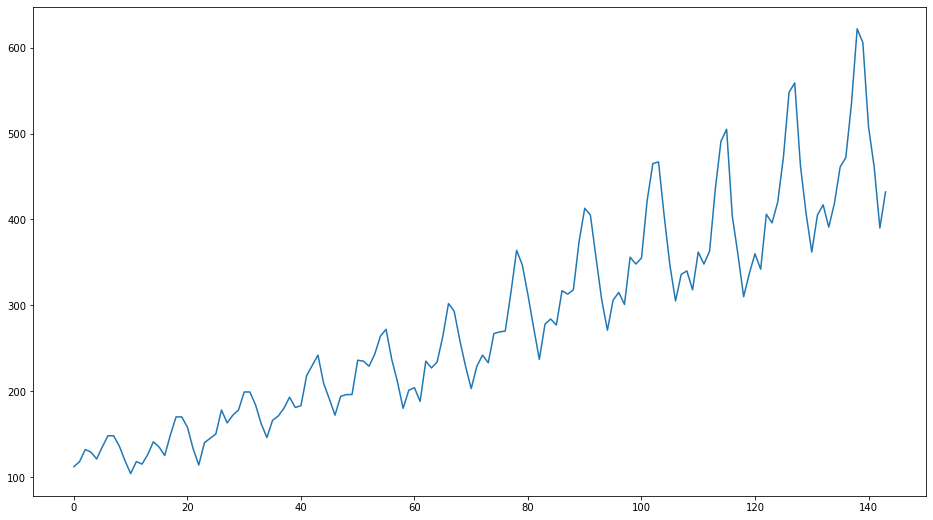

In [40]:
#
# plot number of passangers
#
# Task: plot the passenger data from the pandas dataframe (1 point)
#

df_cut['passengers'].plot()

# Conventional methods

There are many older methods to work with time series:

- https://machinelearningmastery.com/time-series-trends-in-python/
- https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa


The main purpose of these methods is the calculation and use of parameters such as **trend** and **seasonality**. We hope that our models can handle them without us having to explicitly deal with them.

<img src="info.png" align="left"/> 

In [41]:
#
# prepare data
#
x_data = df_cut['passengers'].to_numpy()
x_data = x_data.astype('float32')
x_data = np.reshape(x_data,(-1,1))
print(x_data)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


In [43]:
#
# Normalize the dataset
#
# Task: create a minmax scaler from sklearn to scale the data between 0 and 1 and store the trained scaler in
# a python variable called scaler (2 points)
#
# MinMaxScaler(feature_range=(0.0, 1.0))
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
scaler.fit(x_data)

MinMaxScaler(feature_range=(0.0, 1.0))

In [44]:
print(scaler.data_max_)

[622.]


In [45]:
#
# actually scale the data
#
x_data = scaler.transform(x_data)
print(x_data)

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.1911197 ]
 [0.24

In [47]:
#
# split into train and test sets with 80% training data
#
train_size = int(len(x_data) * 0.80)
test_size = len(x_data) - train_size
train, test = x_data[0:train_size,:], x_data[train_size:len(x_data),:]
print(len(train), len(test))

115 29


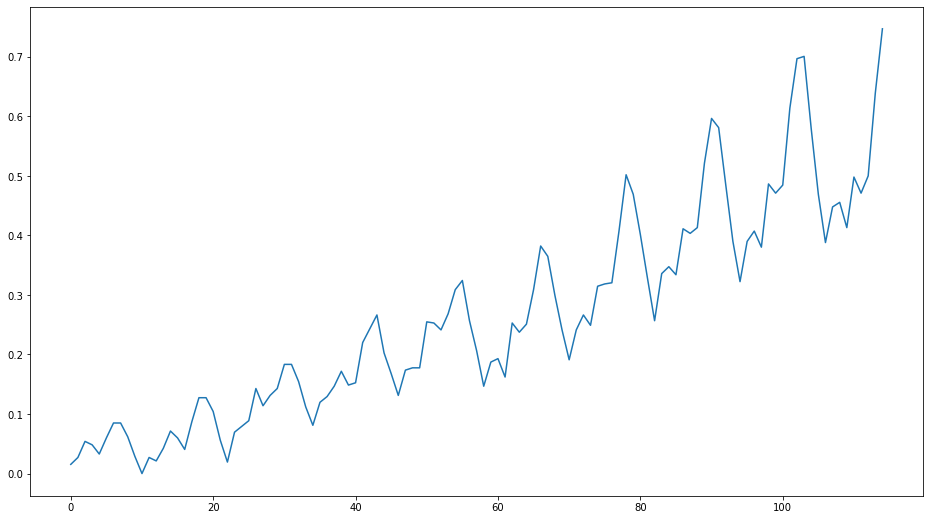

In [48]:
#
# plot scaled training data for check
#
plt.plot(train)

# Create a training data set with sliding windows

Sliding windows are created from a time series by dragging a window over the entire time series and copying the data in the window. More details here [https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe](https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe).

<img src="info.png" align="left"/> 

In [49]:
#
# create sliding windows with one label (y)
#
# Task: add comments for the details of this function (1 point)
#
def createSlidingWindowsWithLabel(dataset, window_length=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_length-1):
        a = dataset[ i:(i+window_length), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_length, 0])
    return np.array(dataX), np.array(dataY)

In [50]:
#
# apply sliding window function with window size (window_length)
#
window_length = 1
trainX, trainY = createSlidingWindowsWithLabel(train, window_length)
testX, testY = createSlidingWindowsWithLabel(test, window_length)

In [51]:
# 
# reshape input to be [samples, time steps, features]
#
trainX = np.reshape(trainX, (trainX.shape[0], window_length, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], window_length, testX.shape[1]))

# Create an LSTM model

In [52]:
# some hyperparameters
epochs = 100
batch_size = 4

In [53]:
#
# create and fit the LSTM network
#
def createLSTMModel():
    model = Sequential()
    model.add(LSTM(6, input_shape=(window_length, 1)))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [54]:
lstm_model = createLSTMModel()

In [55]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = lstm_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(testX, testY), shuffle=False)

Train on 113 samples, validate on 27 samples
Epoch 1/100
113/113 [==============================] - 2s 18ms/step - loss: 0.0808 - val_loss: 0.3618
Epoch 2/100
113/113 [==============================] - 0s 869us/step - loss: 0.0552 - val_loss: 0.2900
Epoch 3/100
113/113 [==============================] - 0s 850us/step - loss: 0.0401 - val_loss: 0.2365
Epoch 4/100
113/113 [==============================] - 0s 891us/step - loss: 0.0309 - val_loss: 0.1962
Epoch 5/100
113/113 [==============================] - 0s 808us/step - loss: 0.0255 - val_loss: 0.1661
Epoch 6/100
113/113 [==============================] - 0s 865us/step - loss: 0.0226 - val_loss: 0.1437
Epoch 7/100
113/113 [==============================] - 0s 880us/step - loss: 0.0210 - val_loss: 0.1272
Epoch 8/100
113/113 [==============================] - 0s 830us/step - loss: 0.0202 - val_loss: 0.1150
Epoch 9/100
113/113 [==============================] - 0s 873us/step - loss: 0.0196 - val_loss: 0.1058
Epoch 10/100
113/113 [=======

113/113 [==============================] - 0s 918us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 80/100
113/113 [==============================] - 0s 777us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 81/100
113/113 [==============================] - 0s 822us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 82/100
113/113 [==============================] - 0s 839us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 83/100
113/113 [==============================] - 0s 778us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 84/100
113/113 [==============================] - 0s 761us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 85/100
113/113 [==============================] - 0s 828us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 86/100
113/113 [==============================] - 0s 915us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 87/100
113/113 [==============================] - 0s 817us/step - loss: 0.0026 - val_loss: 0.0106
Epoch 88/100
113/113 [==============================] - 0s 837us/step - loss:

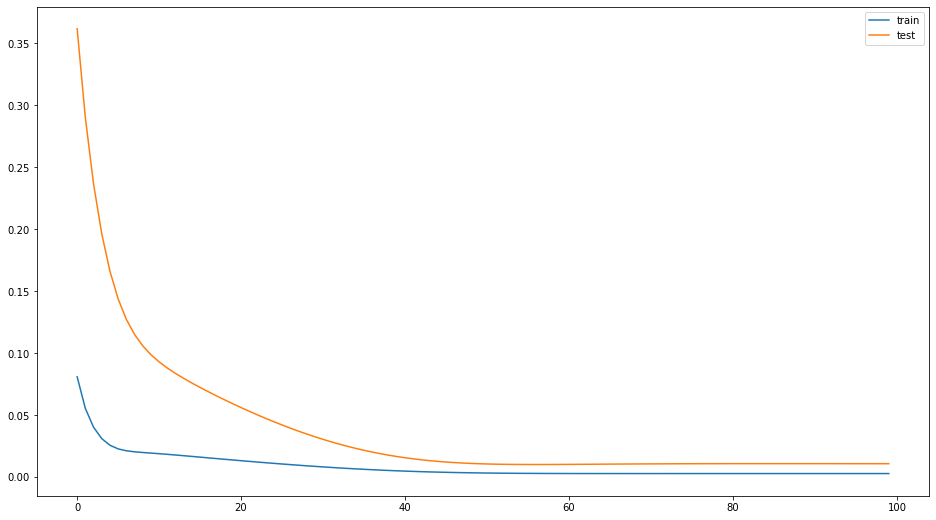

In [57]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [58]:
#
# Estimate values for train and test data
#
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

In [59]:
#
# Inverse transformation of estimations (scaler)
#
trainPredicti = scaler.inverse_transform(trainPredict)
testPredicti = scaler.inverse_transform(testPredict)

trainYi = scaler.inverse_transform([trainY])
testYi = scaler.inverse_transform([testY])

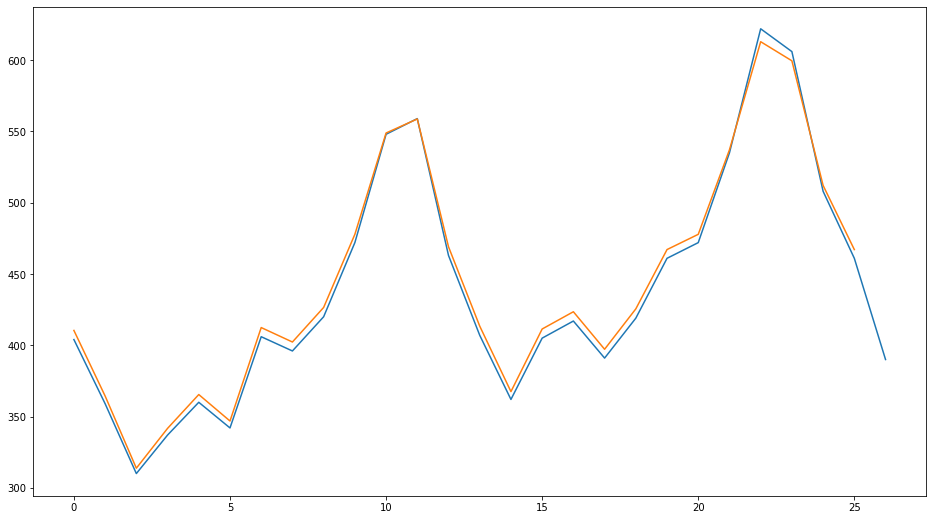

In [60]:
#
# Plot estimations
#
plt.plot(testYi[0,0:])
plt.plot(testPredicti[1:,0])
plt.show()

In [ ]:
#
# calculate root mean squared error
#
# Task: calculate the root mean squared error between the test labels and the prediction (1 point)
# Hint: labels are in testYi[0,0:-1]
#       predictions are in testPredicti[1:,0]

trainScore = ... #math.sqrt
print('train loss: %.3f RMSE' % (trainScore))
testScore = ...
print('test loss: %.3f RMSE' % (testScore))

# Plot complete timeline

In [61]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(x_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[:len(trainPredicti)+0, :] = trainPredicti

# shift test predictions for plotting
testPredictPlot = np.empty_like(x_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredicti)+(look_back*2):len(x_data)-2, :] = testPredicti

NameError: name 'look_back' is not defined

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(x_data), color='grey')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Experiment with different window and model sizes (3 points)

**change request**: The customer wants a better prediction quality. Conduct an experiment with a different window_length. Another option is to increase the capacity of the model. Compare the resulting RMSE values. 
Hopefully, this increases the quality of the prediction.

In [ ]:
#
# apply sliding window function with window size (window_length)
#
window_length = ?
trainX, trainY = createSlidingWindowsWithLabel(train, window_length)
testX, testY = createSlidingWindowsWithLabel(test, window_length)

In [ ]:
# check shape of windows
print(trainX.shape)

In [ ]:
print(trainX)